# Taller 4 PLN

Autor: Guillermo Luigui Ubaldo Nieto Angarita

Rol: Estudiante en Maestría en Analítica Estrategica de Datos

## 0. Instrucciones

- Vectorizar con TF-IDF, Glove, Word2Vec
- Implementar técnicas de Ngrams
- Calcular la distancia del Coseno con los 3 vectorizaciones 
- representar mediante Mapa de calor los resultados de los distancia del Coseno
- Calcular y representar el Top Modeling Mediante LDA.

## 1. Problema de investigación

En el ámbito de los estudios literarios y culturales, los discursos de Mario Vargas Llosa, Albert Camus, Bob Dylan y Gabriel García Márquez representan un patrimonio intelectual de gran valor que trasciende épocas y contextos. Cada uno aborda temáticas diversas que van desde la literatura y la política hasta la música y la condición humana, pero no existe un análisis sistemático que permita determinar qué tan similares o diferentes son estos discursos desde una perspectiva lingüística y semántica. Tradicionalmente, los estudios comparativos de textos y discursos han dependido de métodos cualitativos, los cuales aportan interpretaciones valiosas pero tienden a ser subjetivos y limitados frente a la complejidad del lenguaje. Con los avances en el procesamiento de lenguaje natural es posible aplicar técnicas cuantitativas como el análisis de frecuencias, los n-gramas, las representaciones vectoriales y las métricas de similitud para explorar las relaciones semánticas entre documentos de manera más objetiva y reproducible. El problema de investigación se centra en responder: ¿qué grado de similitud presentan los discursos de Mario Vargas Llosa, Albert Camus, Bob Dylan y Gabriel García Márquez cuando se analizan mediante técnicas de procesamiento de lenguaje natural?

## 2. Objetivos

### 2.1 Objetivo General

Analizar la similitud entre los discursos de Mario Vargas Llosa, Albert Camus, Bob Dylan y Gabriel García Márquez utilizando técnicas de procesamiento de lenguaje natural.

### 2.2 Objetivos Específicos

1. Vectorizar los discursos de Mario Vargas Llosa, Albert Camus, Bob Dylan y Gabriel García Márquez utilizando TF-IDF, Word2Vec y GloVe, incorporando técnicas de N-grams para capturar relaciones entre palabras.

2. Calcular la similitud entre los discursos aplicando la distancia del coseno sobre las diferentes representaciones vectoriales.

3. Visualizar los resultados de las similitudes mediante mapas de calor que faciliten la comparación.

4. Identificar y analizar los temas principales en los discursos a través de topic modeling con LDA.

## 3. Limpieza del texto

### 3.1 Cargar librerías

In [133]:
import re  # Para trabajar con expresiones regulares
import spacy  # Para procesamiento de lenguaje natural (NLP)
import unicodedata  # Para normalizar caracteres Unicode
import stanza
import nltk
import fitz  # PyMuPDF
import docx2txt
import requests
import os
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import networkx as nx

from gensim import corpora
from transformers import AutoTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from flair.data import Sentence
from flair.models import SequenceTagger
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from huggingface_hub import login
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_distances
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer

### 3.2 Descargar los tokenizadores

In [134]:
nltk.download('punkt')
stanza.download('es')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2025-09-13 01:32:04 INFO: Downloaded file to C:\Users\guill\stanza_resources\resources.json
2025-09-13 01:32:04 INFO: Downloading default packages for language: es (Spanish) ...
2025-09-13 01:32:05 INFO: File exists: C:\Users\guill\stanza_resources\es\default.zip
2025-09-13 01:32:08 INFO: Finished downloading models and saved to C:\Users\guill\stanza_resources


In [135]:
nlp_stanza = stanza.Pipeline("es")
nlp_spacy = spacy.load("es_core_news_sm")  #cargar el modelo en español
tokenizer_bert = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

2025-09-13 01:32:08 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-09-13 01:32:08 INFO: Downloaded file to C:\Users\guill\stanza_resources\resources.json
2025-09-13 01:32:09 INFO: Loading these models for language: es (Spanish):
| Processor    | Package           |
------------------------------------
| tokenize     | combined          |
| mwt          | combined          |
| pos          | combined_charlm   |
| lemma        | combined_nocharlm |
| constituency | combined_charlm   |
| depparse     | combined_charlm   |
| sentiment    | tass2020_charlm   |
| ner          | conll02           |

2025-09-13 01:32:09 INFO: Using device: cpu
2025-09-13 01:32:09 INFO: Loading: tokenize
2025-09-13 01:32:09 INFO: Loading: mwt
2025-09-13 01:32:09 INFO: Loading: pos
2025-09-13 01:32:11 INFO: Loading: lemma
2025-09-13 01:32:12 INFO: Loading: constituency
2025-09-13 01:32:12 INFO: Loading: depparse
2025-09-13 01:32:12 INFO: Loading: sentiment
2025-09-13 01:32:13 INFO: Loading: ner
2025-09-13 01:32:14 INFO: Done loading processors!


### 3.3 Descargar Stopwords en Español

In [136]:
nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 3.4 Cargar texto

In [137]:
gabriel_garcia_marquez_text = docx2txt.process("texts/Discuros Gabriel García Marquez.docx")
albert_camus_text = docx2txt.process("texts/Discurso Albert Camus.docx")
bob_dylan_text = docx2txt.process("texts/Discurso Bob Dylan.docx")
vargas_llosa_text = docx2txt.process("texts/Discurso Vargas Llosa.docx")

### 3.5 Leer los Documentos Docx

#### 3.5.1 Leer El Discurso de Gabriel Garcia Marquez

In [138]:
print(gabriel_garcia_marquez_text)

Discurso de aceptación del Premio Nobel

La soledad de América Latina (1982)

Escuche el primer párrafo.



Antonio Pigafetta, un navegante florentino que acompañó a Magallanes en el primer viaje alrededor del mundo, escribió a su paso por nuestra América meridional una crónica rigurosa que sin embargo parece una aventura de la imaginación. Contó que había visto cerdos con el ombligo en el lomo, y unos pájaros sin patas cuyas hembras empollaban en las espaldas del macho, y otros como alcatraces sin lengua cuyos picos parecían una cuchara. Contó que había visto un engendro animal con cabeza y orejas de mula, cuerpo de camello, patas de ciervo y relincho de caballo. Contó que al primer nativo que encontraron en la Patagonia le pusieron enfrente un espejo, y que aquel gigante enardecido perdió el uso de la razón por el pavor de su propia imagen.

Este libro breve y fascinante, en el cual ya se vislumbran los gérmenes de nuestras novelas de hoy, no es ni mucho menos el testimonios más asom

#### 3.5.2 Leer El Discurso de Albert Camus

In [139]:
print(albert_camus_text)

«Al recibir la distinción con que ha querido honrarme su libre Academia, mi gratitud es más profunda cuando evalúo hasta qué punto esa recompensa sobrepasa  mis méritos personales. Todo hombre, y con mayor razón todo artista, desea que se reconozca lo que es o quiere ser. Yo también lo deseo. Pero al conocer su decisión me fue imposible no comparar su resonancia con lo que realmente soy. ¿Cómo un hombre, casi joven todavía, rico sólo por sus dudas, con una obra apenas desarrollada, habituado a vivir en la soledad del trabajo o en el retiro de la amistad, podría recibir, sin una especie de pánico, un galardón que le coloca de pronto, y solo, a plena luz? ¿Con qué ánimo podía recibir ese honor al tiempo que, en tantos sitios, otros escritores, algunos de los más grandes, están reducidos al silencio y cuando, al mismo tiempo, su tierra natal conoce una desdicha incesante?

He sentido esa inquietud, y ese malestar. Para recobrar mi paz interior me ha sido necesario ponerme de acuerdo con u

#### 3.5.3 Leer El Discurso de Bob Dylan

In [140]:
print(bob_dylan_text)

Discurso en el banquete del Nobel, 10 de diciembre de 2016

Buenas noches a todos. Les envío un cordial saludo a los miembros de la Academia Sueca y a todos los distinguidos invitados presentes esta noche.

Lamento no poder estar con ustedes en persona, pero sepan que estoy definitivamente con ustedes en espíritu y me siento honrado de recibir un premio tan prestigioso. Recibir el Premio Nobel de Literatura es algo que nunca podría haber imaginado ni visto venir. Desde muy temprana edad, he estado familiarizado con, leído y absorbido las obras de quienes fueron considerados merecedores de tal distinción: Kipling , Shaw , Thomas Mann , Pearl Buck , Albert Camus , Hemingway . Estos gigantes de la literatura cuyas obras se enseñan en el aula, se albergan en bibliotecas de todo el mundo y se habla de ellas con tonos reverentes siempre han causado una profunda impresión. Que ahora me una a los nombres de tal lista es realmente indescriptible.

No sé si estos hombres y mujeres alguna vez pen

#### 3.5.4 Leer El Discurso de Vargas Llosa

In [141]:
print(vargas_llosa_text)

Elogio de la lectura y la ficción

Aprendí a leer a los cinco años, en la clase del hermano Justiniano, en el Colegio de la Salle, en Cochabamba (Bolivia). Es la cosa más importante que me ha pasado en la vida. Casi setenta años después recuerdo con nitidez cómo esa magia, traducir las palabras de los libros en imágenes, enriqueció mi vida, rompiendo las barreras del tiempo y del espacio y permitiéndome viajar con el capitán Nemo veinte mil leguas de viaje submarino, luchar junto a d’Artagnan, Athos, Portos y Aramís contra las intrigas que amenazan a la Reina en los tiempos del sinuoso Richelieu, o arrastrarme por las entrañas de París, convertido en Jean Valjean, con el cuerpo inerte de Marius a cuestas.

La lectura convertía el sueño en vida y la vida en sueño y ponía al alcance del pedacito de hombre que era yo el universo de la literatura. Mi madre me contó que las primeras cosas que escribí fueron continuaciones de las historias que leía pues me apenaba que se terminaran o quería 

### 3.6 Eliminación de elementos no deseados

In [142]:
def extract_text_without_unwanted_elements(text):
    text = re.sub(r"[^a-zA-Z0-9áéíóúÁÉÍÓÚüÜñÑ\s]", "", text)
    return text

In [143]:
def extract_text_without_unwanted_elements_sentences(text):
    """
    Clean Spanish text but keep sentence delimiters (.!?¡¿) and newlines.
    """
    # Keep Spanish letters, digits, spaces, newlines, and sentence delimiters
    text = re.sub(r"[^a-zA-Z0-9áéíóúÁÉÍÓÚüÜñÑ \n\.\!\?\¡\¿]", "", text)
    
    # Optional: normalize multiple newlines into a single one
    text = re.sub(r"\n+", "\n", text)
    
    return text


### 3.6 Conversión a minúsculas

In [144]:
def convertToLowerCase(text):
    return text.lower()

### 3.7 Transformación UNICODE

In [145]:
def unicodeTransformation(text, method):
    return unicodedata.normalize(method, text)

### 3.8 Tokenización

In [146]:
def stanza_tokenization_words(text):
    doc = nlp_stanza(text)
    return [word.text for sent in doc.sentences for word in sent.words]

In [147]:
def stanza_tokenization_sentences(text):
    """
    Tokenize text into words using Stanza (Spanish).
    Returns: list of tokens per sentence (nested list).
    """
    doc = nlp_stanza(text)
    return [[word.text for word in sent.words] for sent in doc.sentences]

### 3.9 Eliminación de stop words

In [148]:
# --- Function for spaCy ---
def remove_stopwords_spacy(text):
    """
    Return Spanish text without stop words using spaCy
    """
    nlp = spacy.load("es_core_news_sm")
    doc = nlp(text)
    filtered = [token.text for token in doc if not token.is_stop]
    return " ".join(filtered)

### 3.10 Lematización

In [149]:
def lemmatize_with_stanza(text):
    """
    Lemmatize text using Stanza (Spanish pipeline).
    Returns a flat list of lemmas.
    """
    doc = nlp_stanza(text)
    return [word.lemma for sent in doc.sentences for word in sent.words]


In [150]:
def lemmatize_with_stanza_sentences(text):
    """
    Lemmatize text using Stanza.
    Splits into sentences and returns list of lists of lemmas.
    """
    doc = nlp_stanza(text)
    
    lemmatized_sentences = []
    for sent in doc.sentences:
        lemmas = [word.lemma for word in sent.words]
        lemmatized_sentences.append(lemmas)
    
    return lemmatized_sentences


### 3.11 Stemming

In [151]:
# --- Function 2: Stemming with NLTK ---
def stem_spanish(text):
    """
    Stem Spanish text (no stopword removal)
    """
    stemmer = SnowballStemmer("spanish")
    tokens = nltk.word_tokenize(text, language="spanish")
    stems = [stemmer.stem(word) for word in tokens if word.isalpha()]
    return stems

### 3.13 Procedimiento de Textos

In [152]:
def text_processing_pipeline_words(text):
    text_unicode = unicodeTransformation(text, "NFKD")

    text_cleaned = extract_text_without_unwanted_elements(text_unicode)

    text_lower_case = convertToLowerCase(text_cleaned)

    text_without_stop_words = remove_stopwords_spacy(text_lower_case)

    tokens = stanza_tokenization_words(text_without_stop_words)
    
    lammes = lemmatize_with_stanza(' '.join(tokens))
    
    return ' '.join(lammes)

In [153]:
def text_processing_pipeline_sentences(text):
    # Step 1: Unicode normalization
    text_unicode = unicodeTransformation(text, "NFKD")

    # Step 2: Clean unwanted elements
    text_cleaned = extract_text_without_unwanted_elements_sentences(text_unicode)

    # Step 3: Lowercase
    text_lower_case = convertToLowerCase(text_cleaned)

    # Step 4: Remove stopwords
    text_without_stop_words = remove_stopwords_spacy(text_lower_case)

    # Step 5: Lemmatization with Stanza (handles sentence + word tokenization itself)
    lemmatized_sentences = lemmatize_with_stanza_sentences(text_without_stop_words)

    return lemmatized_sentences

### 3.14 Ejecutar Limpieza

In [154]:
gabriel_garcia_marquez_lammes = text_processing_pipeline_words(gabriel_garcia_marquez_text)

In [155]:
albert_camus_lammes = text_processing_pipeline_words(albert_camus_text)

In [156]:
bob_dylan_lammes = text_processing_pipeline_words(bob_dylan_text)

In [157]:
vargas_llosa_lammes = text_processing_pipeline_words(vargas_llosa_text)

In [158]:
gabriel_garcia_marquez_sentences = text_processing_pipeline_sentences(albert_camus_text)

In [159]:
albert_camus_sentences = text_processing_pipeline_sentences(gabriel_garcia_marquez_text)

In [160]:
bob_dylan_sentences = text_processing_pipeline_sentences(bob_dylan_text)

In [161]:
vargas_llosa_sentences = text_processing_pipeline_sentences(vargas_llosa_text)

## 4. Graficas de N-grams

In [162]:
def plot_doc_ngrams(docs, n=2, top_k=10):
    """
    Plot top n-gram frequencies for each document separately.

    Parameters:
    - docs: dict -> {"name": "text", ...}
    - n: int -> n-gram size (2=bigram, 3=trigram, etc.)
    - top_k: int -> number of top n-grams per document
    """
    vectorizer = CountVectorizer(ngram_range=(n,n))
    X = vectorizer.fit_transform(docs.values())
    ngrams = vectorizer.get_feature_names_out()
    counts = pd.DataFrame(X.toarray(), index=docs.keys(), columns=ngrams)

    # Plot per document
    for doc_name in counts.index:
        freqs = counts.loc[doc_name].sort_values(ascending=False).head(top_k)
        freqs = freqs[freqs > 0]  # remove zero counts

        if freqs.empty:
            print(f"No {n}-grams found in {doc_name}")
            continue

        plt.figure(figsize=(8,4))
        sns.barplot(x=freqs.values, y=freqs.index, palette="bright")
        plt.title(f"Top {top_k} {n}-grams in {doc_name}")
        plt.xlabel("Frequency")
        plt.ylabel(f"{n}-gram")
        plt.show()

    return counts

In [163]:
docs = {
    "gabriel_garcia_marquez": gabriel_garcia_marquez_lammes,
    "albert_camus": albert_camus_lammes,
    "bob_dylan": bob_dylan_lammes,
    "vargas_llosa": vargas_llosa_lammes
}

C:\Users\guill\AppData\Local\Temp\ipykernel_18372\2799887917.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs.values, y=freqs.index, palette="bright")


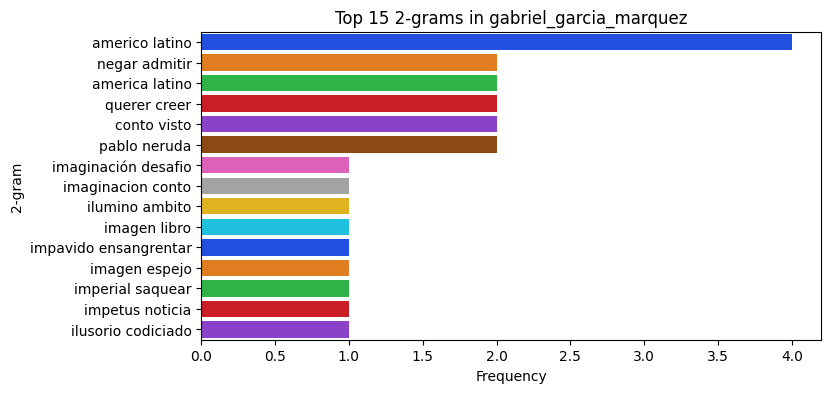

C:\Users\guill\AppData\Local\Temp\ipykernel_18372\2799887917.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs.values, y=freqs.index, palette="bright")


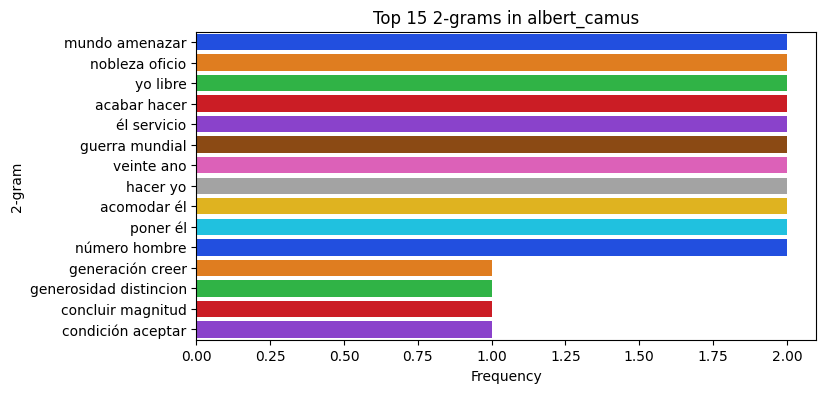

C:\Users\guill\AppData\Local\Temp\ipykernel_18372\2799887917.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs.values, y=freqs.index, palette="bright")


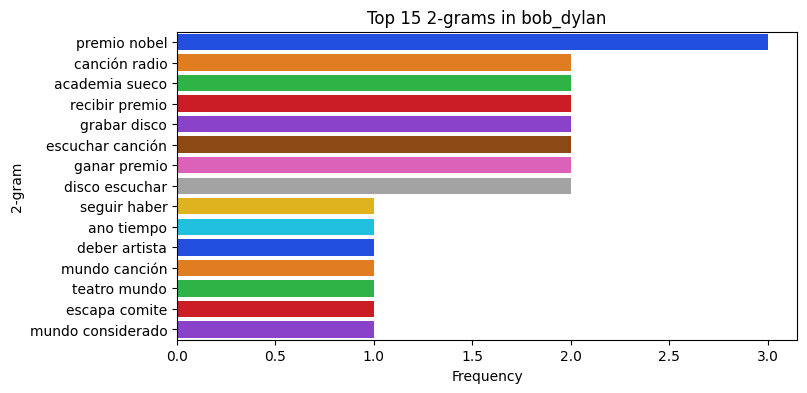

C:\Users\guill\AppData\Local\Temp\ipykernel_18372\2799887917.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs.values, y=freqs.index, palette="bright")


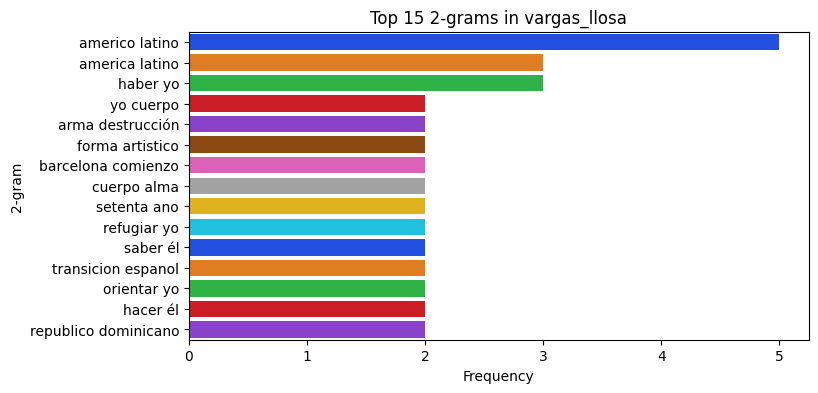

In [164]:
# Run for bigrams
bigrams_table = plot_doc_ngrams(docs, n=2, top_k=15)

C:\Users\guill\AppData\Local\Temp\ipykernel_18372\2799887917.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs.values, y=freqs.index, palette="bright")


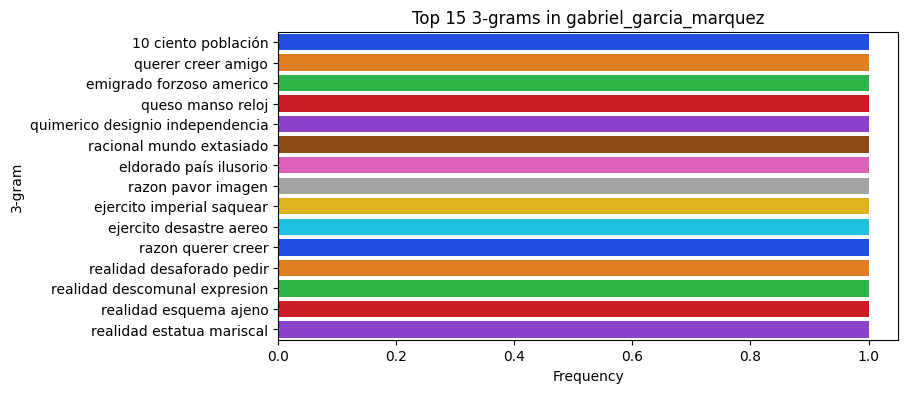

C:\Users\guill\AppData\Local\Temp\ipykernel_18372\2799887917.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs.values, y=freqs.index, palette="bright")


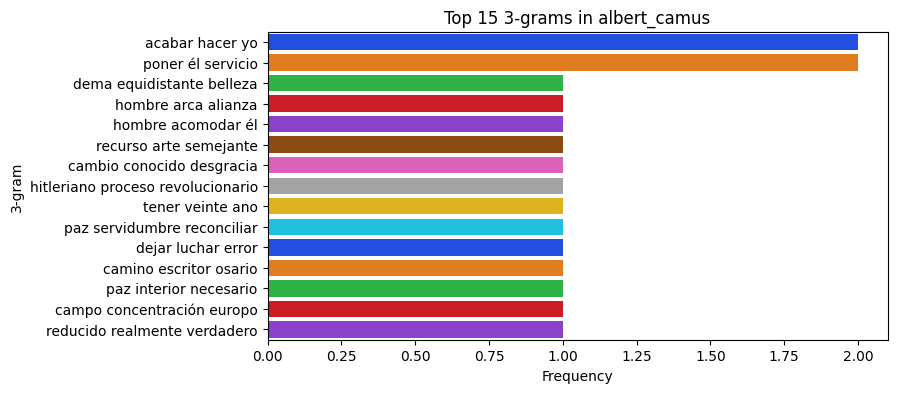

C:\Users\guill\AppData\Local\Temp\ipykernel_18372\2799887917.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs.values, y=freqs.index, palette="bright")


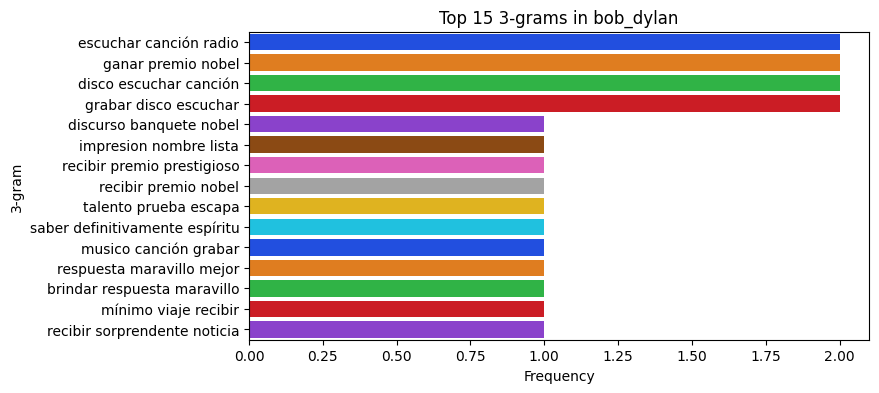

C:\Users\guill\AppData\Local\Temp\ipykernel_18372\2799887917.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs.values, y=freqs.index, palette="bright")


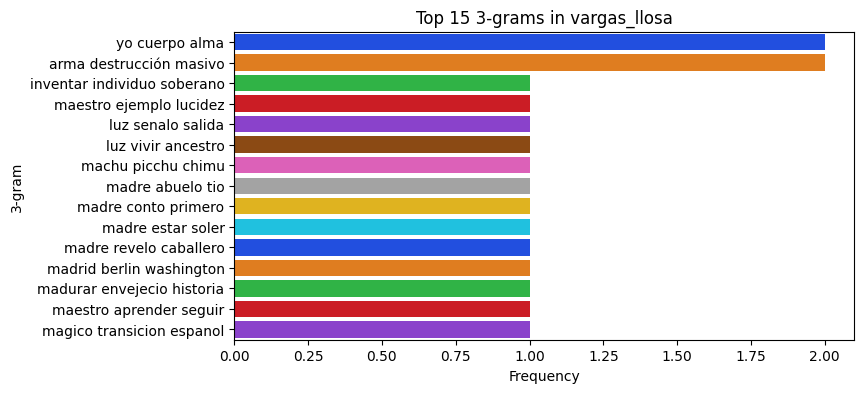

In [165]:
# Run for trigrams
trigrams_table = plot_doc_ngrams(docs, n=3, top_k=15)

In [166]:
def semantic_network_per_doc(docs, n=2, top_k=15):
    """
    Builds and plots semantic networks for each document separately.

    Parameters:
    - docs: dict -> {"name": "text", ...}
    - n: int -> size of n-gram (2=bigram, 3=trigram, etc.)
    - top_k: int -> number of top n-grams to include per document
    """
    vectorizer = CountVectorizer(ngram_range=(n, n))

    for doc_name, text in docs.items():
        # Extract n-grams for the current document
        X = vectorizer.fit_transform([text])
        ngrams = vectorizer.get_feature_names_out()
        freqs = X.toarray().sum(axis=0)

        df = pd.DataFrame({"ngram": ngrams, "freq": freqs})
        df = df.sort_values(by="freq", ascending=False).head(top_k)

        # Build graph
        G = nx.Graph()
        for _, row in df.iterrows():
            words = row["ngram"].split()
            if len(words) == n:
                for i in range(len(words) - 1):
                    G.add_edge(words[i], words[i+1], weight=row["freq"])

        # Skip empty graphs
        if len(G.nodes) == 0:
            print(f"No {n}-grams found in {doc_name}")
            continue

        # Draw graph
        plt.figure(figsize=(8,6))
        pos = nx.spring_layout(G, k=0.5, seed=42)
        edges = G.edges()
        weights = [G[u][v]['weight'] for u,v in edges]

        nx.draw_networkx_nodes(G, pos, node_size=800, node_color="lightblue")
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=[w*0.5 for w in weights], alpha=0.7)
        nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

        plt.title(f"Semantic Network ({n}-grams) - {doc_name}")
        plt.axis("off")
        plt.show()

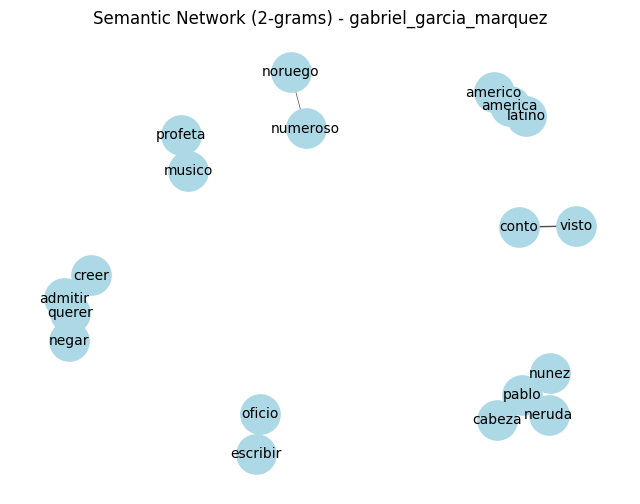

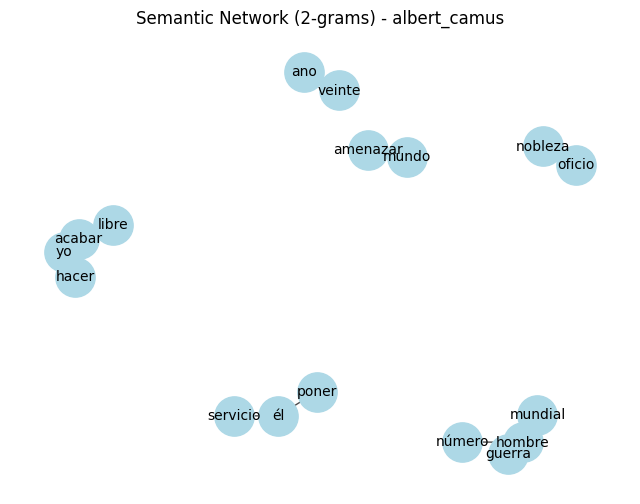

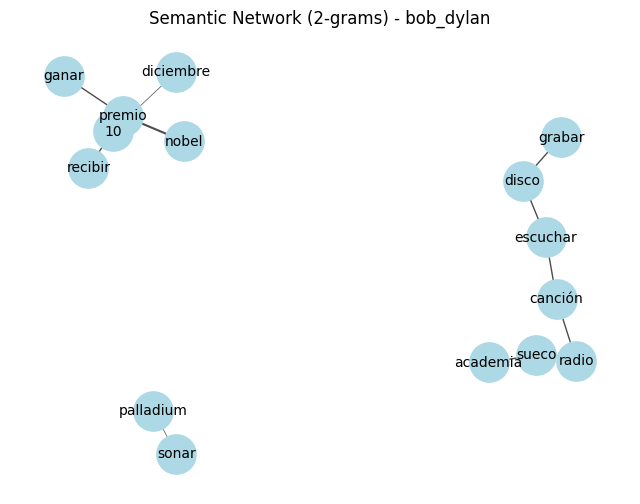

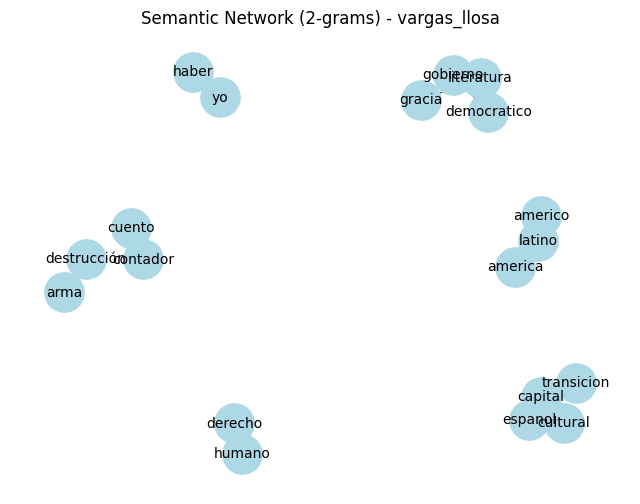

In [167]:
# Per-document bigram networks
semantic_network_per_doc(docs, n=2, top_k=10)

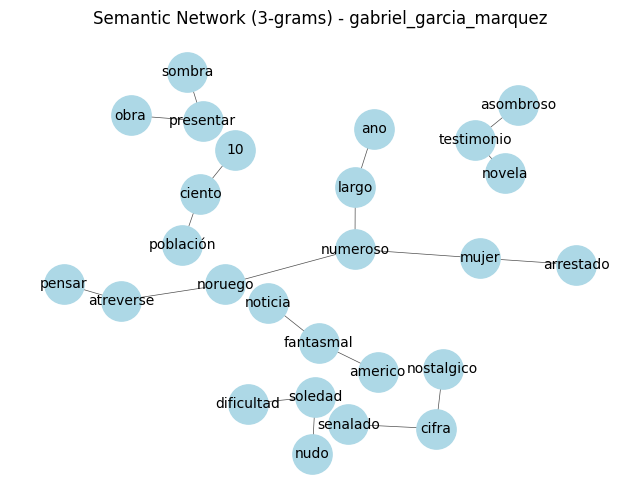

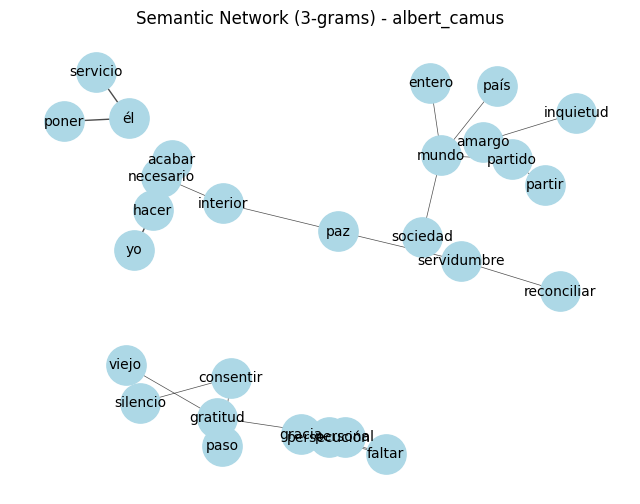

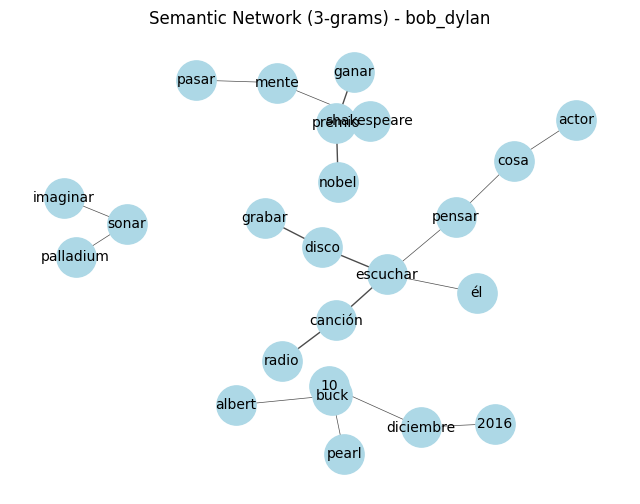

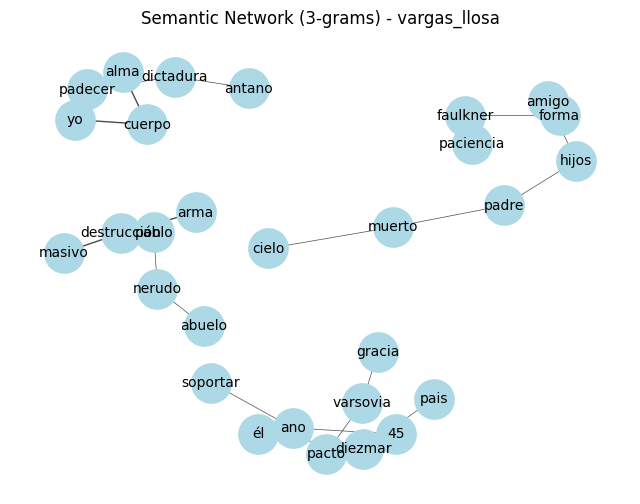

In [168]:
# Per-document trigram networks
semantic_network_per_doc(docs, n=3, top_k=10)

## 5. Vectorización

### 5.1 Vectorización con TF-IDF

In [169]:
# --- Step 1: Combine documents ---
docs = [
    gabriel_garcia_marquez_lammes,
    albert_camus_lammes,
    bob_dylan_lammes,
    vargas_llosa_lammes
]

In [170]:
names = ["gabriel_garcia_marquez", "albert_camus", "bob_dylan", "vargas_llosa"]

In [171]:
# --- Step 2: Fit TF-IDF on all docs ---
# TF-IDF Vectorizer with n-grams (unigrams + bigrams)
vectorizer = TfidfVectorizer(stop_words=None, ngram_range=(1, 2))  
X = vectorizer.fit_transform(docs)  # shape = (4, n_features)

In [172]:
# --- Step 3: Save each document vector separately ---
doc_vectors_tf_idf = {}
for i, name in enumerate(names):
    doc_vectors_tf_idf[name] = X[i]  # sparse vector

### 5.2 Vectorización con GloVe

In [173]:
url = "http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz"
local_path = "glove-sbwc.i25.vec.gz"

if not os.path.exists(local_path) or os.path.getsize(local_path) == 0:
    print(f"Downloading {local_path} ...")
    response = requests.get(url, stream=True)
    response.raise_for_status()
    
    total_size = int(response.headers.get("content-length", 0))
    block_size = 1024  # 1 KB
    
    with open(local_path, "wb") as file, tqdm(
        total=total_size, unit="iB", unit_scale=True
    ) as bar:
        for chunk in response.iter_content(block_size):
            file.write(chunk)
            bar.update(len(chunk))
    
    print("✅ Download complete.")
else:
    print(f"✅ File already exists ({os.path.getsize(local_path)} bytes). No download needed.")

✅ File already exists (949886421 bytes). No download needed.


In [174]:
# Step 1: Load embeddings (works with gzipped file)
def load_embeddings(file_path, vocab=None):
    embeddings = {}
    dim = None
    with gzip.open(file_path, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            if dim is None:  # detect dimension automatically
                dim = len(parts) - 1
            if vocab is None or word in vocab:
                try:
                    vector = np.array(list(map(float, parts[1:])))
                    embeddings[word] = vector
                except ValueError:
                    continue
    return embeddings, dim

In [175]:
# Step 2: Build n-grams
def make_ngrams(docs, n=2, min_count=2, threshold=5):
    if n == 1:
        return docs
    phrases = Phrases(docs, min_count=min_count, threshold=threshold)
    ngram = Phraser(phrases)
    return [ngram[doc] for doc in docs]

In [176]:
# Step 3: Vectorize text
def vectorize_text(tokens, embeddings, dim):
    vecs = []
    for token in tokens:
        if token in embeddings:
            vecs.append(embeddings[token])
        elif "_" in token:  # if it's a bigram/trigram, average components
            parts = token.split("_")
            part_vecs = [embeddings[p] for p in parts if p in embeddings]
            if part_vecs:
                vecs.append(np.mean(part_vecs, axis=0))
    if not vecs:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

In [177]:
docs = [
    gabriel_garcia_marquez_lammes.split(),
    albert_camus_lammes.split(),
    bob_dylan_lammes.split(),
    vargas_llosa_lammes.split()
]


In [178]:
# Build bigrams (set n=1 for unigrams, n=2 for bigrams, n=3 for trigrams)
docs_ngrams = make_ngrams(docs, n=2)

In [179]:
# Collect vocab
all_vocab = set([w for doc in docs_ngrams for w in doc])

In [180]:
# Load only relevant embeddings
local_path = "glove-sbwc.i25.vec.gz"
embeddings, dim = load_embeddings(local_path, all_vocab)

In [181]:
# Get vectors for each document
gabriel_vec_glove = vectorize_text(docs_ngrams[0], embeddings, dim)
camus_vec_glove   = vectorize_text(docs_ngrams[1], embeddings, dim)
dylan_vec_glove   = vectorize_text(docs_ngrams[2], embeddings, dim)
llosa_vec_glove   = vectorize_text(docs_ngrams[3], embeddings, dim)

In [182]:
# === Step 7: Inspect results ===
print("Gabriel García Márquez:", gabriel_vec_glove[:5])
print("Albert Camus:", camus_vec_glove[:5])
print("Bob Dylan:", dylan_vec_glove[:5])
print("Vargas Llosa:", llosa_vec_glove[:5])

Gabriel García Márquez: [-0.04001103  0.06958032 -0.01171007 -0.00868808 -0.00860212]
Albert Camus: [-0.09984587  0.12499387 -0.0056038   0.01600937 -0.02292111]
Bob Dylan: [-0.0386673   0.10300651  0.01630648  0.04457312  0.10302979]
Vargas Llosa: [-0.06080821  0.10940978 -0.02779223 -0.00382199  0.01150396]


### 5.3 Vectorización con Word2Vec

In [183]:
def vectorize_doc_word2vec(sentences, ngram=2, word2vec_model=None, size=100, window=5, min_count=2, sg=1):
    """
    Vectorizes a Spanish document (cleaned & lemmatized, in sentences) using Word2Vec with configurable n-grams.

    Args:
        sentences (list[list[str]]): List of sentences, each as a list of tokens.
        ngram (int): 1=unigrams, 2=bigrams, 3=trigrams, etc.
        word2vec_model (gensim.Word2Vec, optional): Pretrained Word2Vec model. If None, trains a new one.
        size (int): Dimensionality of the Word2Vec vectors.
        window (int): Context window size.
        min_count (int): Minimum frequency count for training Word2Vec.
        sg (int): 1 for skip-gram, 0 for CBOW.

    Returns:
        np.ndarray: Vector representation of the document (averaged word embeddings).
    """

    # Apply n-grams if needed
    sentences_ngrams = sentences
    if ngram > 1:
        for _ in range(1, ngram):
            phrases = Phrases(sentences_ngrams, min_count=min_count, threshold=5)
            phraser = Phraser(phrases)
            sentences_ngrams = [phraser[sent] for sent in sentences_ngrams]

    # Train Word2Vec if no pretrained model provided
    if word2vec_model is None:
        model = Word2Vec(sentences=sentences_ngrams, vector_size=size, window=window, min_count=min_count, sg=sg)
    else:
        model = word2vec_model

    # Collect vectors
    vectors = []
    for sent in sentences_ngrams:
        for w in sent:
            if w in model.wv:
                vectors.append(model.wv[w])

    # Return average vector
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(size)


In [184]:
gabriel_vec_word2vec = vectorize_doc_word2vec(gabriel_garcia_marquez_sentences)
camus_vec_word2vec   = vectorize_doc_word2vec(albert_camus_sentences)
dylan_vec_word2vec   = vectorize_doc_word2vec(bob_dylan_sentences)
llosa_vec_word2vec   = vectorize_doc_word2vec(vargas_llosa_sentences)

In [185]:
print("Norms:")
print(np.linalg.norm(gabriel_vec_word2vec))
print(np.linalg.norm(camus_vec_word2vec))
print (np.linalg.norm(dylan_vec_word2vec))
print (np.linalg.norm(llosa_vec_word2vec ))


Norms:
0.014361786
0.013135534
0.014642931
0.07455462


## 6. Calcular la distancia del coseno utilizando las tres técnicas de vectorización

In [186]:
names = ["gabriel_garcia_marquez", "albert_camus", "bob_dylan", "vargas_llosa"]

# Create a matrix with all document vectors (sparse matrix is fine)

X_all = scipy.sparse.vstack([doc_vectors_tf_idf[name] for name in names])

# Compute pairwise cosine distances
dist_matrix = cosine_distances(X_all)  # distance = 1 - cosine_similarity

# Convert to a DataFrame for easy reading
tf_idf_dist_df = pd.DataFrame(dist_matrix, index=names, columns=names)

print("Cosine Distance Matrix:\n")
print(tf_idf_dist_df)

Cosine Distance Matrix:

                        gabriel_garcia_marquez  albert_camus  bob_dylan  \
gabriel_garcia_marquez                0.000000      0.906189   0.912165   
albert_camus                          0.906189      0.000000   0.921295   
bob_dylan                             0.912165      0.921295   0.000000   
vargas_llosa                          0.816081      0.772624   0.866493   

                        vargas_llosa  
gabriel_garcia_marquez      0.816081  
albert_camus                0.772624  
bob_dylan                   0.866493  
vargas_llosa                0.000000  


In [187]:


# Stack GloVe vectors into a matrix (shape: 4 x vector_size)
glove_matrix = np.vstack([
    gabriel_vec_glove,
    camus_vec_glove,
    dylan_vec_glove,
    llosa_vec_glove
])

# Compute pairwise cosine distances
glove_dist_matrix = cosine_distances(glove_matrix)

# Convert to DataFrame for easy inspection
glove_dist_df = pd.DataFrame(glove_dist_matrix, index=names, columns=names)

print("Cosine Distance Matrix (GloVe document vectors):\n")
print(glove_dist_df)

Cosine Distance Matrix (GloVe document vectors):

                        gabriel_garcia_marquez  albert_camus  bob_dylan  \
gabriel_garcia_marquez                0.000000      0.020096   0.043974   
albert_camus                          0.020096      0.000000   0.041064   
bob_dylan                             0.043974      0.041064   0.000000   
vargas_llosa                          0.015602      0.013744   0.034654   

                        vargas_llosa  
gabriel_garcia_marquez      0.015602  
albert_camus                0.013744  
bob_dylan                   0.034654  
vargas_llosa                0.000000  


In [188]:
# Stack Word2Vec vectors into a matrix (shape: 4 x vector_size)
word2vec_matrix = np.vstack([
    gabriel_vec_word2vec,
    camus_vec_word2vec,
    dylan_vec_word2vec,
    llosa_vec_word2vec
])

# Compute pairwise cosine distances
word2vec_dist_matrix = cosine_distances(word2vec_matrix)

# Convert to DataFrame for readability
word2vec_dist_df = pd.DataFrame(word2vec_dist_matrix, index=names, columns=names)

print("Cosine Distance Matrix (Word2Vec document vectors):\n")
print(word2vec_dist_df)

Cosine Distance Matrix (Word2Vec document vectors):

                        gabriel_garcia_marquez  albert_camus  bob_dylan  \
gabriel_garcia_marquez                0.000000      0.049293   0.084500   
albert_camus                          0.049293      0.000000   0.077522   
bob_dylan                             0.084500      0.077522   0.000000   
vargas_llosa                          0.308195      0.328795   0.450840   

                        vargas_llosa  
gabriel_garcia_marquez      0.308195  
albert_camus                0.328795  
bob_dylan                   0.450840  
vargas_llosa                0.000000  


## 7. Visualizar los resultados de la distancia del coseno mediante un mapa de calor.

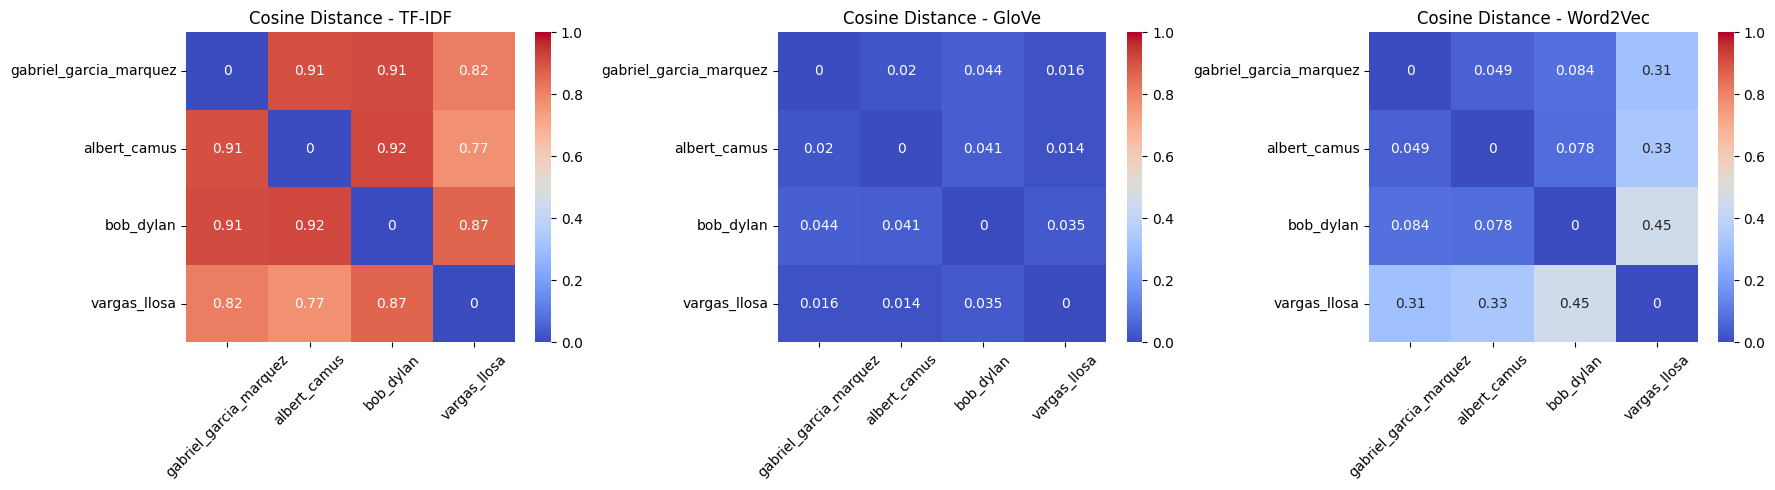

In [189]:
# Assuming you have the distance DataFrames:
# tfidf_dist_df, glove_dist_df, word2vec_dist_df
distance_matrices = {
    "TF-IDF": tf_idf_dist_df,
    "GloVe": glove_dist_df,
    "Word2Vec": word2vec_dist_df
}

# Set figure size
plt.figure(figsize=(18, 5))

for i, (name, dist_df) in enumerate(distance_matrices.items(), 1):
    plt.subplot(1, 3, i)
    sns.heatmap(dist_df, annot=True, cmap="coolwarm", vmin=0, vmax=1)
    plt.title(f"Cosine Distance - {name}")
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Con la técnica de TF-IDF se observa que los discursos presentan valores de distancia coseno altos, entre 0.77 y 0.92. Esto significa que, desde el punto de vista del vocabulario, los textos son poco similares. En otras palabras, cada autor utiliza un conjunto de palabras característico, lo cual refleja estilos de escritura y enfoques distintos en sus discursos.

En el caso de GloVe, los valores de distancia son muy bajos, en el rango de 0.01 a 0.04. Esto indica una gran similitud semántica entre los discursos, ya que este modelo no solo se fija en las palabras exactas, sino en los significados y contextos globales en los que se usan. Así, aunque los autores empleen diferentes términos, sus discursos comparten temas y conceptos relacionados con la literatura, la sociedad o la humanidad.

Por su parte, Word2Vec muestra resultados intermedios, con valores que van de 0.04 a 0.45. Este modelo permite distinguir mejor las diferencias semánticas entre los discursos. Se observa, por ejemplo, que los textos de Gabriel García Márquez y Albert Camus son bastante cercanos en significado, mientras que el discurso de Mario Vargas Llosa aparece más alejado de los demás, lo que sugiere que aborda temáticas distintas.

En conjunto, estos resultados indican que, aunque los discursos difieren notablemente en el uso del vocabulario, a nivel semántico mantienen una cercanía importante. Sin embargo, existen diferencias claras en el enfoque de ciertos autores, siendo Vargas Llosa el que se distancia más en comparación con los demás escritores.

## 8. Realizar el cálculo y la representación del Topic Modeling utilizando LDA.

In [190]:
docs = [
    gabriel_garcia_marquez_lammes,
    albert_camus_lammes,
    bob_dylan_lammes,
    vargas_llosa_lammes
]


In [191]:
tokenized_docs = [doc.split() for doc in docs]
print(tokenized_docs[0][:20])  # show first 20 tokens of García Márquez

['discurso', 'aceptación', 'premio', 'nobel', 'soledad', 'america', 'latino', '1982', 'escuchar', 'parrafo', 'antonio', 'pigafetta', 'navegante', 'florentino', 'acompano', 'magallan', 'viaje', 'mundo', 'escribio', 'paso']


In [192]:
dictionary = corpora.Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [193]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2,    # try 2, 3, 4... depends on your goal
    passes=20,
    random_state=42
)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.006*"él" + 0.006*"ano" + 0.005*"hombre" + 0.005*"mundo" + 0.004*"vida" + 0.004*"yo" + 0.004*"vivir" + 0.004*"tiempo" + 0.003*"mil" + 0.003*"cuyo"
Topic 1: 0.009*"él" + 0.008*"vida" + 0.007*"yo" + 0.006*"literatura" + 0.006*"historia" + 0.006*"mundo" + 0.005*"vivir" + 0.005*"escribir" + 0.005*"ano" + 0.004*"tiempo"


In [194]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.060589  0.0       1        1  64.973275
0     -0.060589  0.0       2        1  35.026725, topic_info=           Term       Freq      Total Category  logprob  loglift
342      hombre  10.000000  10.000000  Default  30.0000  30.0000
419  literatura  20.000000  20.000000  Default  29.0000  29.0000
578      poesia   4.000000   4.000000  Default  28.0000  28.0000
775        arte   5.000000   5.000000  Default  27.0000  27.0000
461         mil   7.000000   7.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
340    historia   4.826363  23.623786   Topic2  -5.8332  -0.5391
404      latino   3.691265   9.719904   Topic2  -6.1014   0.0809
598      querer   3.691799  11.138433   Topic2  -6.1012  -0.0552
518        obra   3.125885   6.314079   Topic2  -6.2676   0.3460
604     recibir   3.125517   6.314171   Topic2  -6.2677   0.3459

[151 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
9         2  0.853910        20
31        2  0.853918   admitir
1274      1  0.863195  alcanzar
52        1  0.526876   americo
52        2  0.526876   americo
...     ...       ...       ...
1083      2  0.131754    volver
748       1  0.747239        yo
748       2  0.237758        yo
750       1  0.750027        él
750       2  0.258630        él

[160 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

El primer tópico identificado en el modelo (Tópico 1) está asociado principalmente con términos como literatura, libro, lengua, palabra, historia, cultura, sociedad, escritor y vida. Estos términos reflejan un enfoque orientado hacia el papel de la literatura como construcción cultural y social. La recurrencia de palabras como historia y cultura sugiere una relación estrecha entre la producción literaria y los procesos colectivos de identidad, memoria y transmisión del conocimiento. En este sentido, este tópico representa la dimensión académica y cultural de la literatura, donde se pone de relieve cómo los libros y el lenguaje se convierten en medios para comprender la sociedad y su desarrollo histórico.

El segundo tópico (Tópico 2), en contraste, está conformado por términos como vida, mundo, tiempo, hombre, libertad, realidad, soledad, poesía, artista y muerte. A diferencia del primero, este tópico se centra en una perspectiva existencial y personal de la experiencia humana. Aquí, la literatura se entiende como una herramienta para reflexionar sobre la condición del ser humano, sus emociones y dilemas universales. Palabras como soledad, libertad y muerte remiten a preocupaciones filosóficas y vitales, mientras que la presencia de poesía y artista conecta con la dimensión creativa y estética. También se evidencian matices de identidad geográfica y cultural, como lo muestran términos relacionados con lo latino o lo americano.

Al comparar ambos tópicos, se observa que representan dos grandes ejes temáticos dentro del corpus analizado. Por un lado, el Tópico 1 aborda la función social y cultural de la literatura, destacando su rol en la construcción de memoria colectiva e identidad histórica. Por otro lado, el Tópico 2 profundiza en la dimensión existencial y artística, vinculando la creación literaria con la experiencia personal, las emociones y las reflexiones sobre la vida y la muerte. La separación clara entre ambos círculos en el mapa de distancias confirma que se trata de temáticas diferenciadas, aunque complementarias, que reflejan tanto la función social como el sentido humano y creativo de la literatura.

## 8. Conclusion

Los resultados muestran que los discursos son muy distintos en las palabras que usan (TF-IDF), pero en el fondo hablan de temas muy parecidos cuando se analizan los significados (GloVe y Word2Vec). Es decir, cada autor tiene su propio estilo y vocabulario, pero todos comparten reflexiones sobre la literatura, la sociedad y la vida humana. El análisis de tópicos confirma esta idea: un grupo de temas se relaciona con la función social y cultural de la literatura, mientras que otro se enfoca en la dimensión personal y existencial de la experiencia humana. En resumen, aunque los discursos se expresan de manera diferente, coinciden en los grandes temas que abordan.